## Cubic Grid

Cubic and uniform grids, like in other packages are useful mainly for visualization purposes. In Grid, the implemented cubic, uniform, and tensor1D grids can be used integrate and interpolate functions.


### Example: Visualize $2p_{z}$ Orbital using Tensor 1D Grid

Given a function $f(x, y, z)$, (e.g. an atomic orbital or electron density) we can evaluate it on a cubic grid and visualize the distribution of the function in space using isosurface values. Here we define a function that plots every point in the grid with a corresponding absolute value of the function greater than a threshold value. The function ris latter used to visualize the $2p_{z}$ orbital.


#### Define utility function for plotting


In [133]:
# Define a function to plot the grid points according to their values


# function to plot grid points bigger than a given threshold
def plot_isosurface(
    grid, vals, isovalue, *, both_signs=True, at_data=None, noticks=False, title=None
):
    """Plot grid points with values bigger than isovalue.

    The function plots the grid points with absolute values bigger than isovalue.

    Parameters
    ----------
    grid : Grid
        Cartesian grid (it can be uniform or TensorProductGrid) with 3 dimensions.
    vals : ndarray
        Values of the function on the grid points.
    isovalue : float
        Value of the isosurface to plot.
    both_signs : bool, optional
        If True, plot points with negative values too. The default is True.
    at_data : tuple, optional
        Tuple containing the atomic coordinates and atomic labels. If not None,
        it should be a tuple containing (atcoords, atlabels) where atcoords is
        a ndarray of shape (natoms, 3) containing the atomic coordinates in
        bohr and atlabels is a list of length natoms containing the atomic labels.
    title : str, optional
        Title of the plot. The default is None.
    """
    # indices of points with values close to isovalue
    idx_p_vals = np.where(vals > isovalue)
    idx_n_vals = np.where(vals < -isovalue)

    # points with values close to isovalue
    p_pts = grid.points[idx_p_vals]
    n_pts = grid.points[idx_n_vals]

    xmin, xmax = np.min(grid.points[:, 0]), np.max(grid.points[:, 0])
    ymin, ymax = np.min(grid.points[:, 1]), np.max(grid.points[:, 1])
    zmin, zmax = np.min(grid.points[:, 2]), np.max(grid.points[:, 2])

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    if noticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    if at_data is not None:
        if len(at_data) != 2:
            raise ValueError("at_data should be a tuple containing (atcoords, atlabels)")

        atcoords, atlabels = at_data

        if atcoords.shape[0] != len(atlabels):
            raise ValueError("atcoords and atlabels should have the same length")

        # if there are more than 2 atoms set the view point perpendicular to the molecular plane
        if len(atlabels) > 2:
            # Calculate the centroid of atomic coordinates
            centroid = np.mean(atcoords, axis=0)
            # Center the atomic coordinates by subtracting the centroid from each point
            centered_coords = atcoords - centroid
            # Perform Singular Value Decomposition (SVD) on the centered coordinates
            _, _, V = np.linalg.svd(centered_coords)
            # The normal vector the molecular plane is the last column of the V matrix
            normal_vector = V[-1]

            # Set the view point perpendicular to the plane
            ax.view_init(
                elev=np.degrees(np.arcsin(normal_vector[2])),
                azim=np.degrees(np.arctan2(normal_vector[1], normal_vector[0])),
            )

        # plot the atomic centers
        # ax.scatter(atcoords[:, 0], atcoords[:, 1], atcoords[:, 2], color="k", s=50)
        for i in range(len(atlabels)):
            ax.text(
                atcoords[i, 0],
                atcoords[i, 1],
                atcoords[i, 2],
                atlabels[i],
                color="k",
                fontsize=12,
                horizontalalignment="center",
                verticalalignment="center",
            )

    # set axis limits
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_zlim((zmin, zmax))

    # plot points with values bigger than isovalue
    ax.scatter(
        p_pts[:, 0], p_pts[:, 1], p_pts[:, 2], alpha=0.01, color="r", label=f"Positive values"
    )
    if both_signs:
        ax.scatter(
            n_pts[:, 0], n_pts[:, 1], n_pts[:, 2], alpha=0.01, color="b", label=f"Negative values"
        )

    legend = plt.legend(loc="upper right")
    for lh in legend.legendHandles:
        lh.set_alpha(1)

    # ax.set_xlabel("X-axis")
    # ax.set_ylabel("Y-axis")
    # ax.set_zlabel("Z-axis")

    if title is not None:
        plt.title(title)
    plt.show()

#### Plot $2p_{z}$ orbital from isosurface value


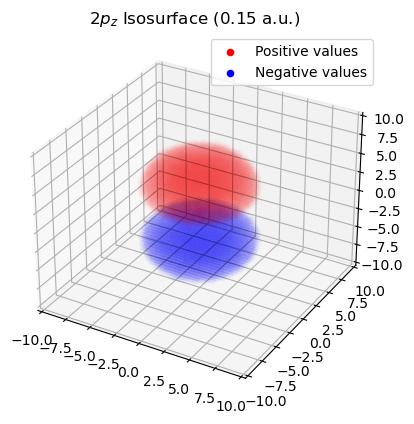

In [134]:
from grid.onedgrid import UniformInteger
from grid.rtransform import LinearInfiniteRTransform
from grid.cubic import Tensor1DGrids
import matplotlib.pyplot as plt
import numpy as np

# Construct a grid covering from -10 to 10 in each dimension with 50 points.
npoints = 50
limit = 10
oned_grid = UniformInteger(npoints)
oned_grid = LinearInfiniteRTransform(-limit, limit).transform_1d_grid(oned_grid)

# Constructing the tensor product grid.
tensor_grid = Tensor1DGrids(oned_grid, oned_grid, oned_grid)


# define 2pz orbital function
def psi_2pz(x, y, z, a_0):
    r = np.sqrt(x**2 + y**2 + z**2)
    return np.exp(-r / (2 * a_0)) * z


# Evaluate the function on the grid.
psi_vals = psi_2pz(*tensor_grid.points.T, a_0=1.0)

point_idx = target_x = 0.15
tolerance = 1e-2

plot_isosurface(tensor_grid, psi_vals, target_x, title="$2p_{z}$ Isosurface (0.15 a.u.)")

### Example: Calculate and Visualize Dual Descriptor of Formaldehyde

This example on illustates the use of Grid with the [IOData](https://github.com/theochem/iodata) package to compute and visualize the dual descriptor of formaldehyde. The dual descriptor is a function of electron density and its derivatives and is defined as:

$$f^{(2)}(r) = \Delta f(r) = (f^{+}(r) - f^{-}(r)$$

where $f^{+}(r)$ and $f^{-}(r)$ are the Fukui functions defined as:

$$f^{+}(r) = \left(\frac{\partial \rho(r)}{\partial \rho^2}\right)^{+}_{\upsilon(r)} = \rho_{N+1}(r) - \rho_{N}(r)$$

$$f^{-}(r) = \left(\frac{\partial \rho(r)}{\partial \rho^2}\right)^{-}_{\upsilon(r)} = \rho_{N}(r) - \rho_{N-1}(r)$$

then $f^{(2)}(r)$ can be written as:

$$f^{(2)}(r) = \rho_{N+1}(r) - \rho_{N-1}(r)$$


#### Calculate and visualize dual descriptor

The dual descriptor is evaluated at each grid point as the difference between the electron density of the anion and cation of formaldehyde. The electron density can be evaluated in the grid points using the [GBasis](https://github.com/theochem/gbasis) package with the wavefunction read from the `.fchk` files of formaldehyde anion and cation. The latter are read using the [IOData](https://github.com/theochem/iodata) package. The `.fchk` files are included in `doc/notebooks/ch2o_q-1.fchk` and `doc/notebooks/ch2o_q+1.fchk` respectively.

##### 1. Define utility function calculate dual descriptor


In [135]:
from gbasis.evals.density import evaluate_density


# load formaldehyde cation and anion fchk files
mol_anion = load_one("ch2o_q-1.fchk")
mol_cation = load_one("ch2o_q+1.fchk")

# Construct molecular basis from wave-function information read by IOData
basis_cat, type_cat = from_iodata(mol_cation)
basis_an, type_an = from_iodata(mol_anion)

# get rdms for cation and anion
rdm_cat = mol_cation.one_rdms["scf"]
rdm_an = mol_anion.one_rdms["scf"]


# define function to compute dual descriptor on a grid
def compute_dual_descriptor(grid, rdm_an, rdm_cat, basis_an, basis_cat, type_an, type_cat):
    """Compute dual descriptor on a grid.

    Parameters
    ----------
    grid : Grid
        Grid object.
    rdm_an : np.ndarray
        1-RDM of the anion.
    rdm_cat : np.ndarray
        1-RDM of the cation.
    basis_an : list
        Basis set of the anion.
    basis_cat : list
        Basis set of the cation.
    type_an : str
        Coordinate type of the anion.
    type_cat : str
        Coordinate type of the cation.
    """
    # evaluate electron density of cation and anion on the grid
    dens_vals_cat = evaluate_density(rdm_cat, basis_cat, grid.points, coord_type=type_cat)
    dens_vals_an = evaluate_density(rdm_an, basis_an, grid.points, coord_type=type_an)

    # compute dual descriptor on the grid
    return dens_vals_an - dens_vals_cat

##### 2. Calculate and visualize dual descriptor


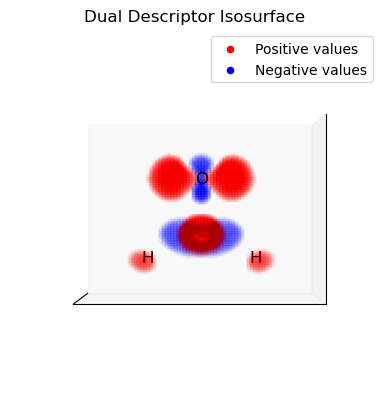

Positive values (red) correspond to nucleophilic regions
Negative values (blue) correspond to electrophilic regions


In [136]:
from iodata import load_one
from gbasis.wrappers import from_iodata
from grid.cubic import UniformGrid


# load formaldehyde cation and anion fchk files
mol_anion = load_one("ch2o_q-1.fchk")
mol_cation = load_one("ch2o_q+1.fchk")

# Construct molecular basis from wave-function information read by IOData
basis_cat, type_cat = from_iodata(mol_cation)
basis_an, type_an = from_iodata(mol_anion)

# get rdms for cation and anion
rdm_cat = mol_cation.one_rdms["scf"]
rdm_an = mol_anion.one_rdms["scf"]


atcoords = mol_anion.atcoords
atnums = mol_anion.atnums

# construct uniform grid
uniform_grid = UniformGrid.from_molecule(atnums, atcoords, spacing=0.1, extension=2.0, rotate=True)

# compute dual descriptor on the grid
dd = compute_dual_descriptor(uniform_grid, rdm_an, rdm_cat, basis_an, basis_cat, type_an, type_cat)

# plot dual descriptor isosurface
mol_data = (atcoords, ["O", "C", "H", "H"])
plot_isosurface(
    uniform_grid, dd, 0.03, at_data=mol_data, title="Dual Descriptor Isosurface", noticks=True
)

print(f"Positive values (red) correspond to nucleophilic regions")
print(f"Negative values (blue) correspond to electrophilic regions")

#### Integrate dual descriptor domains

[Grid](https://github.com/theochem/grid) Grids are easy to manipulate and integrate. Here we integrate the different lobes of the dual descriptor. This can be used to assess the relevance of electrophilic and nucleophilic regions of the molecule.

##### 1. Define utility function to extract dual descriptor domains


In [137]:
# define utility function for grouping grid points in domains
from itertools import combinations
from scipy.sparse.csgraph import connected_components


# function to get grid points indices for same sign connected points with absolute
# value  greater than a threshold (select domain defined by isovalue)
def get_domains(grid, vals, isovalue):
    """Get grid points indices for domains with same sign connected points.

    The function returns the indices of the grid points that belong to the same domain. A domain
    is defined by a set of connected points with the same sign and absolute value greater than
    isovalue.

    Parameters
    ----------
    grid : Grid
        Cartesian grid (it can be uniform or TensorProductGrid) with 3 dimensions.
    vals : ndarray
        Values of the function on the grid points.
    isovalue : float
        Value of the isosurface used to define the domains.

    Returns
    -------
    tuple
        Tuple containing two lists. The first list contains domains with positive values and the
        second list contains domains with negative values. Each domain is a np.array with the
        indexes of the grid points that belong to the same domain.
    """
    # indices of points with value modulus greater than isovalue
    idx_p_vals = np.where(vals > isovalue)[0]  # positive values
    idx_n_vals = np.where(vals < -isovalue)[0]  # negative values

    # create adjacency matrix selected points with same sign
    p_vals_adj = np.zeros((len(idx_p_vals), len(idx_p_vals)))
    n_vals_adj = np.zeros((len(idx_n_vals), len(idx_n_vals)))

    # try all combinations of selected points with same sign (positive values)
    for i, j in combinations(range(len(idx_p_vals)), 2):
        # get coordinate indices of the points
        i_coord_idx = np.array(grid.index_to_coordinates(idx_p_vals[i]))
        j_coord_idx = np.array(grid.index_to_coordinates(idx_p_vals[j]))
        # two points are adjacent if they differ by at most 1 in each coordinate index
        if np.max(np.abs(i_coord_idx - j_coord_idx)) == 1:
            p_vals_adj[i, j] = 1

    # try all combinations of selected points with same sign (negative values)
    for i, j in combinations(range(len(idx_n_vals)), 2):
        i_coord_idx = np.array(grid.index_to_coordinates(idx_n_vals[i]))
        j_coord_idx = np.array(grid.index_to_coordinates(idx_n_vals[j]))
        # two points are adjacent if they differ by at most 1 in each coordinate
        if np.max(np.abs(i_coord_idx - j_coord_idx)) == 1:
            n_vals_adj[i, j] = 1

    # returns an array of integers, each integer represents domain and the indexes where
    # it appear are the points belonging to that domain
    # example: [0,1,0,0,1,1] -> points 0,2,3 belong to domain 0
    #                        -> points 1,4,5 belong to domain 1
    p_groups = connected_components(p_vals_adj, directed=False)[1]
    n_groups = connected_components(n_vals_adj, directed=False)[1]

    # creates a list with the domains. Each element of the list is a np.array with the indexes
    # of the selected points that belong to the same domain.
    # example: [0,1,0,0,1,1] -> [[0,2,3],[1,4,5]]
    p_domains = list([np.where(p_groups == i)[0] for i in range(max(p_groups) + 1)])
    n_domains = list([np.where(n_groups == i)[0] for i in range(max(n_groups) + 1)])

    # transform indexes of selected points to indexes of all grid points for each domain
    p_domains = [idx_p_vals[domain] for domain in p_domains]
    n_domains = [idx_n_vals[domain] for domain in n_domains]

    return p_domains, n_domains

##### 2. Select and integrate the positive (electrophilic) domains of the dual descriptor


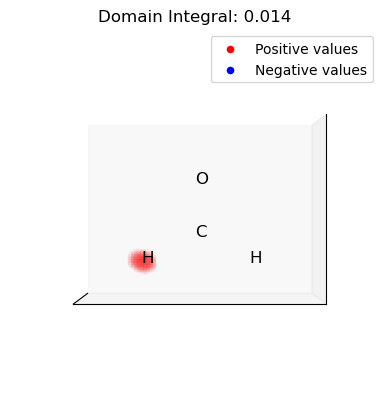

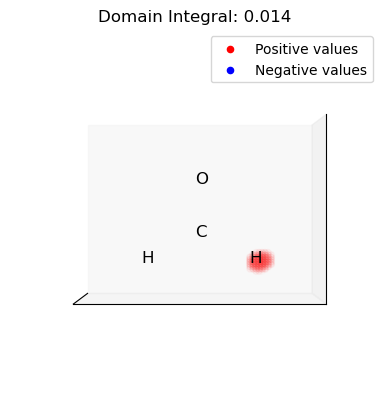

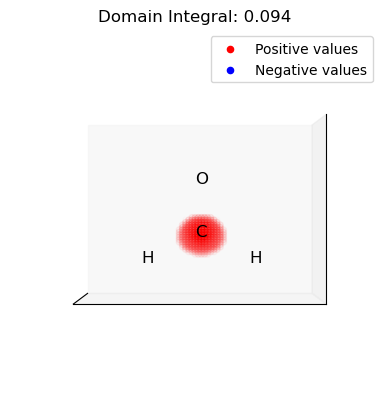

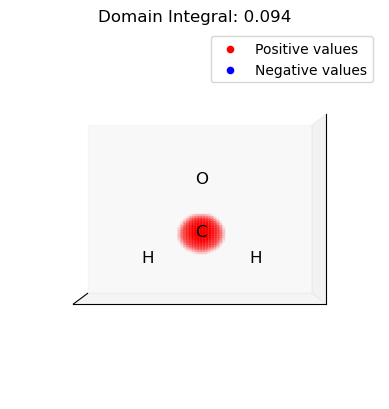

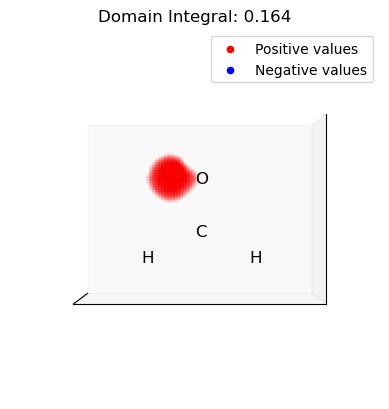

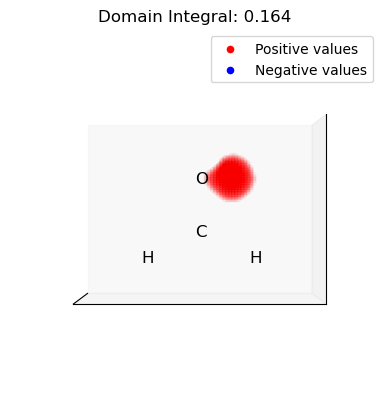

In [138]:
# get dual descriptor domains, integrate and plot them
p_domains, n_domains = get_domains(uniform_grid, dd, 0.03)

for domain in p_domains:
    domain_vals = dd.copy()
    domain_mask = np.isin(np.arange(len(dd)), domain, invert=True)
    domain_vals[domain_mask] = 0.0

    plot_isosurface(
        uniform_grid,
        domain_vals,
        0.001,
        at_data=at_data,
        title=f"Domain Integral: {uniform_grid.integrate(domain_vals):.3f}",
        noticks=True,
    )

##### 3. Select and integrate the negative (nucleophilic) domains of the dual descriptor


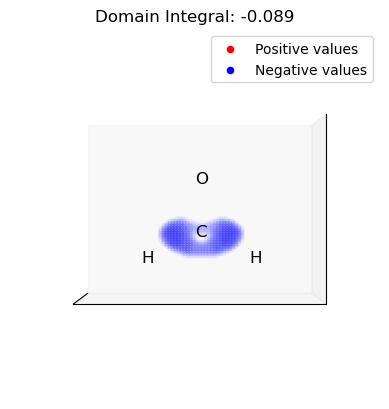

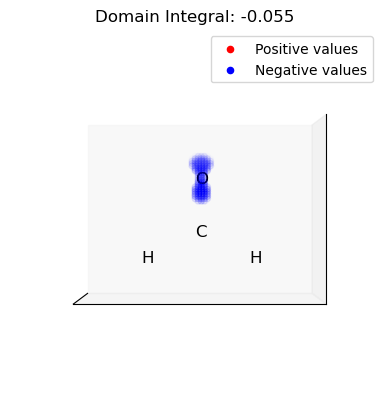

In [139]:
for domain in n_domains:
    domain_vals = dd.copy()
    domain_mask = np.isin(np.arange(len(dd)), domain, invert=True)
    domain_vals[domain_mask] = 0.0

    plot_isosurface(
        uniform_grid,
        domain_vals,
        0.001,
        at_data=at_data,
        title=f"Domain Integral: {uniform_grid.integrate(domain_vals):.3f}",
        noticks=True,
    )

## Periodic Grid

[Periodic grids](../pyapi/grid.periodicgrid) used to evaluate integrals over periodic systems. These grid support models for wires, surfaces or solids.
